## ipfp

In [1]:
ipfp = function(Xvals, Yvals, A, sigma=1)
{
    phis = kronecker(t(Yvals),t(Xvals))  
    dX=dim(Xvals)[2]
    dY=dim(Yvals)[2]
    n=dim(Xvals)[1]
    if (n!=dim(Yvals)[1]) {stop("Dimensions of Xvals and Yvals do not match.")}
    
    p=rep(1/n,n)
    q=rep(1/n,n)
    IX=rep(1,n)
    tIY=matrix(rep(1,n),nrow=1)
    f = p %*% tIY
    g = IX %*% t(q)
    pihat = diag(n)/n
    v=rep(0,n)
    
    Phi = Xvals %*% A %*% t(Yvals)
    contIpfp = TRUE
    iterIpfp = 0
    while(contIpfp)
    {
        iterIpfp = iterIpfp+1
        u = sigma*log(apply(g * exp( ( Phi - IX %*% t(v) ) / sigma ),1,sum))
        vnext = sigma*log(apply(f * exp( ( Phi - u %*% tIY ) / sigma ),2,sum))
        error = max(abs(apply(g * exp( ( Phi - IX %*% t(vnext) - u %*% tIY ) / sigma ),1,sum)-1))
        if( (error<tolIpfp) | (iterIpfp >= maxiterIpfp)) {contIpfp=FALSE}
        v=vnext
    }

    pi = f * g * exp( ( Phi - IX %*% t(v) - u %*% tIY ) / sigma )
    
    if (iterIpfp >= maxiterIpfp ) {stop('maximum number of iterations reached')} 
    
    ######## the fro objective
    fro = norm(phis %*% c(pi - pihat) , "f") 
    
    ########
    thegrad = c(phis %*% c(pi - pihat))
    theval = sum(thegrad * c(A)) - sigma * sum(pi*log(pi))
    return(list(theval=theval,fro=fro))

}

## affinity

In [2]:
affinity=function(Xvals, Yvals, sigma=1, lambda=1)
{
    phis = kronecker(t(Yvals),t(Xvals))  
    dX=dim(Xvals)[2]
    dY=dim(Yvals)[2]
    n=dim(Xvals)[1]
    if (n!=dim(Yvals)[1]) {stop("Dimensions of Xvals and Yvals do not match.")}
    
    p=rep(1/n,n)
    q=rep(1/n,n)
    IX=rep(1,n)
    tIY=matrix(rep(1,n),nrow=1)
    f = p %*% tIY
    g = IX %*% t(q)
    pihat = diag(n)/n
    v=rep(0,n)
    
    A = rep(0,dX*dY)
    t_k = .3   # step size for the prox grad algorithm (or grad descent when lambda=0)
    
    iterCount = 0
    
    while (1)
    {
        # compute pi_A
        Phi = Xvals %*% matrix(A,nrow=dX) %*% t(Yvals)
        contIpfp = TRUE
        iterIpfp = 0
        while(contIpfp)
        {
            iterIpfp = iterIpfp+1
            u = sigma*log(apply(g * exp( ( Phi - IX %*% t(v) ) / sigma ),1,sum))
            vnext = sigma*log(apply(f * exp( ( Phi - u %*% tIY ) / sigma ),2,sum))
            error = max(abs(apply(g * exp( ( Phi - IX %*% t(vnext) - u %*% tIY ) / sigma ),1,sum)-1))
            if( (error<tolIpfp) | (iterIpfp >= maxiterIpfp)) {contIpfp=FALSE}
            v=vnext
        }

        pi = f * g * exp( ( Phi - IX %*% t(v) - u %*% tIY ) / sigma )
        
        if (iterIpfp >= maxiterIpfp ) {stop('maximum number of iterations reached')} 
        
        
        # do prox grad descent
        thegrad = c(phis %*% c(pi - pihat))

        # take one gradient step
        A = A - t_k*thegrad
        
        if (lambda > 0)
        {
            # compute the proximal operator
            SVD = svd(matrix(A,nrow=dX))
            U = SVD$u
            D = SVD$d
            V = SVD$v
                
            D = pmax(D - lambda*t_k, 0.)
            A = c(U %*% diag(D) %*% t(V))
        } # if lambda = 0 then we are just taking one step of gradient descent
            

        ### testing optimality
        if (iterCount %% 10 == 0)
        {
            alpha = 1.
            tmp = svd(matrix(A - alpha * thegrad, nrow=dX))
            tmp_second = sum((A - c(tmp$u %*% diag(pmax(tmp$d - alpha*lambda, 0.)) %*% t(tmp$v)))^2)
            cat("testing optimality ", tmp_second, "\n")
        }
        
        if (lambda > 0)
        {
            theval = sum(thegrad * c(A)) - sigma * sum(pi*log(pi)) + lambda * sum(D)
        } else
        {
            theval = sum(thegrad * c(A)) - sigma * sum(pi*log(pi))
        }
        
        iterCount = iterCount + 1
        
        if (iterCount>1 && abs(theval - theval_old) < 1E-6)
        {
            break
        }
        
        theval_old = theval
        
    }

    return(matrix(A,nrow=dX))

}

## run the actual code

Loading required package: lattice
Loading required package: ggplot2


 [1] 2 5 1 4 1 3 2 3 5 5
experiment is  1 
lambda is  0 
testing optimality  3.494461 
testing optimality  0.02745065 
testing optimality  0.005024823 
testing optimality  0.001381407 
testing optimality  0.0004574714 
testing optimality  0.0001690784 
testing optimality  6.718888e-05 
testing optimality  2.808365e-05 
testing optimality  1.217309e-05 
testing optimality  5.419791e-06 
testing optimality  3.508795 
testing optimality  0.02701892 
testing optimality  0.004513879 
testing optimality  0.00117927 
testing optimality  0.0003891558 
testing optimality  0.0001473481 
testing optimality  6.072658e-05 
testing optimality  2.641964e-05 
testing optimality  1.191056e-05 
testing optimality  5.499779e-06 
testing optimality  3.874145 
testing optimality  0.02505029 
testing optimality  0.004273008 
testing optimality  0.00110933 
testing optimality  0.0003517745 
testing optimality  0.0001255826 
testing optimality  4.83777e-05 
testing optimality  1.960983e-05 
testing optimality

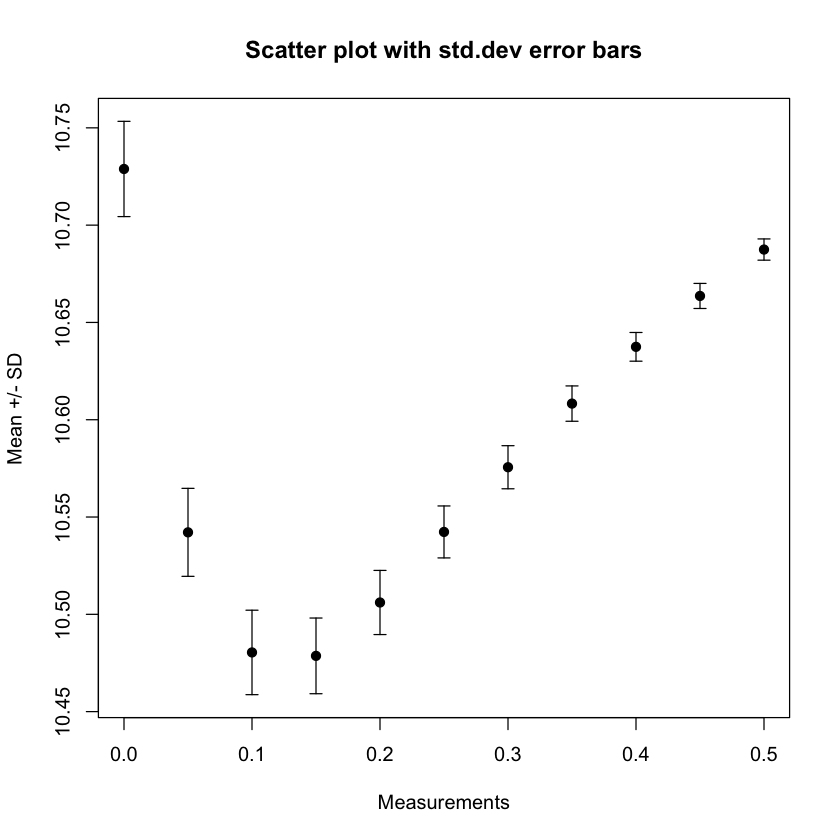

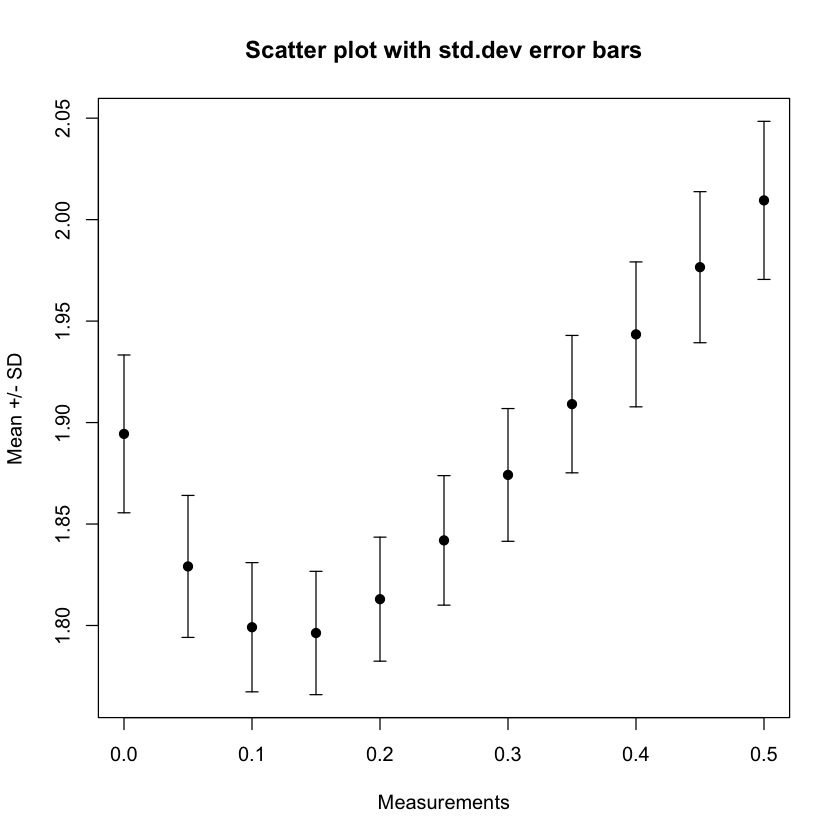

In [3]:
mydata <- read.csv("DGS_low_rank_april16.csv")
Xvals = mydata[,c(1:22, 45:48)]
Yvals = mydata[,c(23:44, 56:59)]

library(caret)

tolIpfp = 1E-12
maxiterIpfp = 1000

seed = 777
set.seed(seed)

###### data preprocessing
# compute the mean and std
meanX = apply(Xvals,2,mean)
meanY = apply(Yvals,2,mean)
sdX = apply(Xvals,2,sd)
sdY = apply(Yvals,2,sd)

Xvals = t( t(Xvals) - meanX )
Yvals = t( t(Yvals) - meanY )
Xvals = t( t(Xvals) / sdX)
Yvals = t( t(Yvals) / sdY)


### starts cross validation here
nfold = 5
nrep  = 2  # repeat nfold-cv nRep times

lambda_list = seq(0,0.5,length=11)
error_array = matrix(0, length(lambda_list), nfold*nrep)
fro_array   = matrix(0, length(lambda_list), nfold*nrep)

for (experiment in 1:nrep){
    # for each experiment, i.e. nfold-cv we will need to re-generate the indices
    indices <- createFolds(1:1155, k = nfold, list = FALSE, returnTrain = FALSE)
    print(indices[1:10])   # just to make sure the indices are indeed different
    
    for (j in 1:length(lambda_list)){
        
        lambda_val = lambda_list[j]
        cat("experiment is ", experiment, "\n")
        cat("lambda is ", lambda_val, "\n")
        
        for (i in 1:nfold) {
            Xvals_train_cv = Xvals[indices!=i,]
            Yvals_train_cv = Yvals[indices!=i,]
            Xvals_test_cv  = Xvals[indices==i,]
            Yvals_test_cv  = Yvals[indices==i,]
            
            A_cv = affinity(Xvals_train_cv,Yvals_train_cv,sigma=1,lambda=lambda_val)
            # evaluate test set performance
            sol_cv = ipfp(Xvals_test_cv, Yvals_test_cv, A_cv, sigma=1)
            error_array[j,i+nfold*(experiment-1)] = sol_cv$theval
            fro_array[j,i+nfold*(experiment-1)] = sol_cv$fro
        }
    }
}

mean_error = apply(error_array,1,mean)
std_error  = apply(error_array,1,sd) / sqrt(nfold*nrep)

mean_fro = apply(fro_array,1,mean)
std_fro  = apply(fro_array,1,sd) / sqrt(nfold*nrep)

plot(lambda_list, mean_error,
     ylim=range(c(mean_error-std_error, mean_error+std_error)),
     pch=19, xlab="Measurements", ylab="Mean +/- SD",
     main="Scatter plot with std.dev error bars"
)
arrows(lambda_list, mean_error-std_error, lambda_list, mean_error+std_error, length=0.05, angle=90, code=3)

plot(lambda_list, mean_fro,
     ylim=range(c(mean_fro-std_fro, mean_fro+std_fro)),
     pch=19, xlab="Measurements", ylab="Mean +/- SD",
     main="Scatter plot with std.dev error bars"
)
arrows(lambda_list, mean_fro-std_fro, lambda_list, mean_fro+std_fro, length=0.05, angle=90, code=3)

testing optimality  2.120862 
testing optimality  0.0009746847 
testing optimality  2.535137e-05 
 [1] 3.977792e-01 3.267099e-01 2.453573e-01 1.947053e-01 1.733050e-01
 [6] 1.601258e-01 1.347154e-01 1.000096e-01 8.143677e-02 4.521863e-02
[11] 4.267287e-02 1.467046e-02 3.247812e-17 3.247812e-17 3.247812e-17
[16] 3.247812e-17 3.247812e-17 3.247812e-17 3.247812e-17 3.247812e-17
[21] 3.247812e-17 3.247812e-17 3.247812e-17 3.247812e-17 3.247812e-17
[26] 2.228840e-17


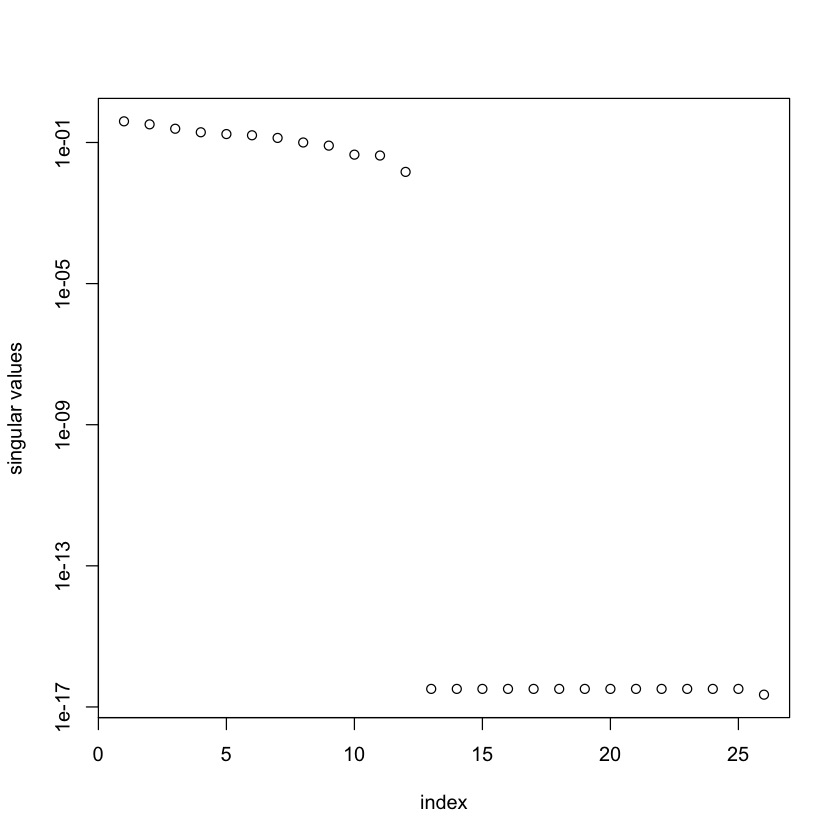

In [4]:
res_regularized = affinity(Xvals,Yvals,sigma=1,lambda=0.15)
print(svd(res_regularized)$d)
plot(svd(res_regularized)$d, log='y', xlab="index", ylab="singular values")